In [2]:
import datetime
import fnmatch
import matplotlib.cbook
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import numpy as np
import os
import glob
import pandas as pd
import pickle
import platform
from pylab import rcParams
import scipy
from scipy import stats
import warnings


warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
startTimeNotebook = datetime.datetime.now()
if 'COLAB_GPU' in os.environ:
    !git clone https://github.com/HeathenToaster/code
    %cd code

# session lists in a .py file
# import sessionlists
%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/test.mplstyle')

In [3]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/sequencesALLDATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 34 rats in the data folder


In [4]:
rat_markers = {}
params = {}
nb_runsBin = {}
speedRunToLeftBin, speedRunToRightBin = {}, {}
timeRunToLeftBin, timeRunToRightBin = {}, {}
maxSpeedLeftBin, maxSpeedRightBin = {}, {}
timeStayInLeftBin, timeStayInRightBin = {}, {}
totalDistance, totalWater, total_trials = {}, {}, {}
XtrackRunToLeftBin, XtrackRunToRightBin = {}, {}
instantSpeedLeftBin, instantSpeedRightBin = {}, {}
trackTimeToLeftBin, trackTimeToRightBin = {}, {}
sequence = {}

# # define colors for each rat
# palette = {'RatF00': (0.4, 0.0, 0.0), 'RatF01': (0.55, 0.13, 0.13), 'RatF02': (0.8, 0.2, 0.2),
#            'RatM00': (0.0, 0.4, 0.0), 'RatM01': (0.13, 0.55, 0.13), 'RatM02': (0.2, 0.8, 0.2),
#            'RatF20': (0.4, 0.0, 0.0), 'RatF21': (0.55, 0.13, 0.13), 'RatF22': (0.8, 0.2, 0.2),
#            'RatM20': (0.0, 0.4, 0.0), 'RatM21': (0.13, 0.55, 0.13), 'RatM22': (0.2, 0.8, 0.2),
#            'RatF30': (0.4, 0.0, 0.0), 'RatF31': (0.55, 0.13, 0.13), 'RatF32': (0.8, 0.2, 0.2), 'RatF33': (0.8, 0.2, 0.2),
#            'RatM30': (0.0, 0.4, 0.0), 'RatM31': (0.13, 0.55, 0.13), 'RatM32': (0.2, 0.8, 0.2), 
#            'RatF30L': (0.4, 0.0, 0.0), 'RatF31L': (0.55, 0.13, 0.13), 'RatF32L': (0.8, 0.2, 0.2), 'RatF33L': (0.8, 0.2, 0.2),
#            'RatM30L': (0.0, 0.4, 0.0), 'RatM31L': (0.13, 0.55, 0.13), 'RatM32L': (0.2, 0.8, 0.2)}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
            #    'RatF20': 'thcre', 'RatF21': 'thcre', 'RatF22': 'thcre',
            #    'RatM20': 'thcre', 'RatM21': 'thcre', 'RatM22': 'thcre',
               'RatF30': 'DLS', 'RatF31': 'DLS', 'RatF32': 'normal', 'RatF33': 'normal',
               'RatM30': 'DLS', 'RatM31': 'normal', 'RatM32': 'normal',
               'RatF40': 'DLS', 'RatF41': 'DMS', 'RatF42': 'normal',
               'RatM40': 'normal', 'RatM41': 'DLS', 'RatM42': 'DMS', 'RatM43': 'normal', 

                'RatF50': 'DMS', 'RatF51': 'DLS', 'RatF52': 'DLS',
               'RatM50': 'DMS', 'RatM51': 'DMS', 'RatM52': 'DLS', 'RatM53': 'normal', 'RatM54': 'normal'
               }

intact_map = plt.cm.get_cmap('winter')
lesion_map = plt.cm.get_cmap('autumn')

# markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
# lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

markers = {'normal': 'o', 'DLS': 'X', 'DMS': 'x'}
lines = {'normal': '-', 'DLS': '-', 'DMS': '-'}
colormaps = {'normal': intact_map, 'DLS': lesion_map, 'DMS': lesion_map}

# RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']


for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 'd', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 's', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    # loop over all sessions for each rat and get the pickled preprocessed data. Data is processed in VIGOR_Preprocess.py
    # data (list or list of lists) for each variable is stored in a dictionary with keys (animal, session)
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):
                                                #  dist60bis+dist90bis+dist120bis)):

        # get the preprocessed data from the pickle file
        # In this notebook we only need the sequence of events, so we only load that
        biglesion = True if 'L' in session else False
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)

        params[animal, session]     = get_from_pickle(root, animal[0:6], session, name="params.p", biglesion=biglesion)
        nb_runsBin[animal, session] = get_from_pickle(root, animal[0:6], session, name="nbRuns.p", biglesion=biglesion)
        speedRunToLeftBin[animal, session],  speedRunToRightBin[animal, session]  = get_from_pickle(root, animal[0:6], session, name="avgSpeed.p", biglesion=biglesion)
        maxSpeedLeftBin[animal, session],    maxSpeedRightBin[animal, session]    = get_from_pickle(root, animal[0:6], session, name="maxSpeed.p", biglesion=biglesion)
        timeStayInLeftBin[animal, session],  timeStayInRightBin[animal, session]  = get_from_pickle(root, animal[0:6], session, name="timeinZone.p", biglesion=biglesion)
        timeRunToLeftBin[animal, session],   timeRunToRightBin[animal, session]   = get_from_pickle(root, animal[0:6], session, name="timeRun.p", biglesion=biglesion)
        XtrackRunToLeftBin[animal, session], XtrackRunToRightBin[animal, session] = get_from_pickle(root, animal[0:6], session, name="trackPos.p", biglesion=biglesion)
        instantSpeedLeftBin[animal, session],instantSpeedRightBin[animal, session]= get_from_pickle(root, animal[0:6], session, name="trackSpeed.p", biglesion=biglesion)
        trackTimeToLeftBin[animal, session], trackTimeToRightBin[animal, session] = get_from_pickle(root, animal[0:6], session, name="trackTime.p", biglesion=biglesion)
        totalDistance[animal, session],      totalWater[animal, session], total_trials[animal, session] = get_from_pickle(root, animal[0:6], session, name="misc.p", biglesion=biglesion)


Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF30
Loading data for RatF31
Loading data for RatF32
Loading data for RatF33
Loading data for RatM30
Loading data for RatM31
Loading data for RatM32
Loading data for RatF40
Loading data for RatF41
Loading data for RatF42
Loading data for RatM40
Loading data for RatM41
Loading data for RatM42
Loading data for RatM43
Loading data for RatF50
Loading data for RatF51
Loading data for RatF52
Loading data for RatM50
Loading data for RatM51
Loading data for RatM52
Loading data for RatM53
Loading data for RatM54


In [5]:

for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 'd', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 's', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF30
Loading data for RatF31
Loading data for RatF32
Loading data for RatF33
Loading data for RatM30
Loading data for RatM31
Loading data for RatM32
Loading data for RatF40
Loading data for RatF41
Loading data for RatF42
Loading data for RatM40
Loading data for RatM41
Loading data for RatM42
Loading data for RatM43
Loading data for RatF50
Loading data for RatF51
Loading data for RatF52
Loading data for RatM50
Loading data for RatM51
Loading data for RatM52
Loading data for RatM53
Loading data for RatM54


In [6]:
# separate the data into time and reward bins for each experimental condition
# distances 
data60IDLE = prepare_data_idle_times(sequence, animalList, dist60)
data90IDLE = prepare_data_idle_times(sequence, animalList, dist90)
data120IDLE = prepare_data_idle_times(sequence, animalList, dist120)

data60RUN = prepare_data_running_times(sequence, animalList, dist60)
data90RUN = prepare_data_running_times(sequence, animalList, dist90)
data120RUN = prepare_data_running_times(sequence, animalList, dist120)

# treadmill speeds
data20IDLE = prepare_data_idle_times(sequence, animalList, TM20)
data10IDLE = prepare_data_idle_times(sequence, animalList, TM10)
data2IDLE = prepare_data_idle_times(sequence, animalList, TM2+TMrev2)
datarev10IDLE = prepare_data_idle_times(sequence, animalList, TMrev10)
datarev20IDLE = prepare_data_idle_times(sequence, animalList, TMrev20)

data20RUN = prepare_data_running_times(sequence, animalList, TM20)
data10RUN = prepare_data_running_times(sequence, animalList, TM10)
data2RUN = prepare_data_running_times(sequence, animalList, TM2+TMrev2)
datarev10RUN = prepare_data_running_times(sequence, animalList, TMrev10)
datarev20RUN = prepare_data_running_times(sequence, animalList, TMrev20)

# all conditions pooled
dataAllIDLE = prepare_data_idle_times(sequence, animalList, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)
dataAllRUN = prepare_data_running_times(sequence, animalList, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)


In [50]:
modelrun_fit(datarev10RUN['RatM30'])

(array([1.8016341 , 0.        , 0.17853375, 0.        , 0.01888058,
        0.        ]),
 1.2283634682708113)

In [51]:
def modelrun_fit(data, init=[1.56, 0, 0.05, 0, 0.048, 0], f=modelrun_crit,
                 N_bins=6, N_avg=4, N_params=2,
                 mu_t_fixed=False, sigma_t_fixed=False,
                 mu_R_fixed=False, sigma_R_fixed=False):
    params_init = np.array(init)
    mu_t_bounds = (None, None) if not mu_t_fixed else (0, 1e-8)
    sigma_t_bounds = (None, None) if not sigma_t_fixed else (0, 1e-8)
    mu_R_bounds = (None, None) if not mu_R_fixed else (0, 1e-8)
    sigma_R_bounds = (None, None) if not sigma_R_fixed else (0, 1e-8)

    res = minimize(f, params_init, args=(data, [N_bins, N_avg], N_params),
                   bounds=((None, None), (None, None),
                           mu_t_bounds, sigma_t_bounds,
                           mu_R_bounds, sigma_R_bounds))
    return res.x, res.fun


def modelrun_crit(params, *args, robustness_param=1e-20):
    mu, sigma, mu_prime, sigma_prime, mu_second, sigma_second = params
    l = 0
    N_bins, N_avg = args[1]
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = mu + bin*mu_prime + avg*mu_second
            SIGMA[bin, avg] = sigma + bin*sigma_prime + avg*sigma_second

    for bin in range(N_bins):
        for avg in range(N_avg):
            _mu = MU[bin, avg]# if MU[bin, avg] > 0 else 1e-8
            _sigma = SIGMA[bin, avg] if SIGMA[bin, avg] > 0 else 1e-8

            if len(args[0][bin][avg]) > 0:
                loss = (_mu - np.nanmedian(args[0][bin][avg]))**2
            else:
                loss = 1e-8
            # n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
            l += loss
    return l

In [52]:

alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False
mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed = False, False, False, False

alpha, gamma, alpha_t, gamma_t, alpha_R, gamma_R, lossWald = {}, {}, {}, {}, {}, {}, {}
mu, mu_t, mu_R, sigma, sigma_t, sigma_R, loss = {}, {}, {}, {}, {}, {}, {}


# def modelrun_fit(data, init=[1, 1, 1, 1, 1, 1], f=modelrun_crit,
#                  N_bins=6, N_avg=4, N_params=2,
#                  mu_t_fixed=False, sigma_t_fixed=False,
#                  mu_R_fixed=False, sigma_R_fixed=False):
#     params_init = np.array(init)
#     mu_t_bounds = (None, None) if not mu_t_fixed else (0, 1e-8)
#     sigma_t_bounds = (None, None) if not sigma_t_fixed else (0, 1e-8)
#     mu_R_bounds = (None, None) if not mu_R_fixed else (0, 1e-8)
#     sigma_R_bounds = (None, None) if not sigma_R_fixed else (0, 1e-8)

#     res = minimize(f, params_init, args=(data, [N_bins, N_avg], N_params),
#                    bounds=((None, None), (None, None),
#                            mu_t_bounds, sigma_t_bounds,
#                            mu_R_bounds, sigma_R_bounds))
#     return res.x, res.fun


for animal in animalList:
    alpha[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    lossWald[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}

    mu[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    sigma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    mu_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    sigma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    mu_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    sigma_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    loss[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}


    for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60IDLE, data90IDLE, data120IDLE, data20IDLE, data10IDLE, data2IDLE, datarev10IDLE, datarev20IDLE]):
        (alpha[animal][cond], theta, gamma[animal][cond], \
        alpha_t[animal][cond], thetaprime, gamma_t[animal][cond], \
        alpha_R[animal][cond], thetasecond, gamma_R[animal][cond]), lossWald[animal][cond] = modelwald_fit(data[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                        gamma_t_fixed=gamma_t_fixed, 
                                                                                                                        alpha_R_fixed=alpha_R_fixed, 
                                                                                                                        gamma_R_fixed=gamma_R_fixed)

    for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60RUN, data90RUN, data120RUN, data20RUN, data10RUN, data2RUN, datarev10RUN, datarev20RUN]):
        (mu[animal][cond], sigma[animal][cond], \
        mu_t[animal][cond], sigma_t[animal][cond], \
        mu_R[animal][cond], sigma_R[animal][cond]), loss[animal][cond] = modelrun_fit(data[animal], mu_t_fixed=mu_t_fixed, 
                                                                                                    sigma_t_fixed=sigma_t_fixed, 
                                                                                                    mu_R_fixed=mu_R_fixed, 
                                                                                                    sigma_R_fixed=sigma_R_fixed,)



In [53]:
# animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
#               'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
#               'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43']
pickle.dump([alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R,], open("picklejar/intact_lesionFITS.p", "wb"))
alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))


# animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
#             'RatF32', 'RatF33', 'RatM31', 'RatM32', 
#             'RatF42', 'RatM40', 'RatM43']
# pickle.dump([alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R,], open("picklejar/intactFITS.p", "wb"))
# alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R = pickle.load(open("picklejar/intactFITS.p", "rb"))

# zscore on intact

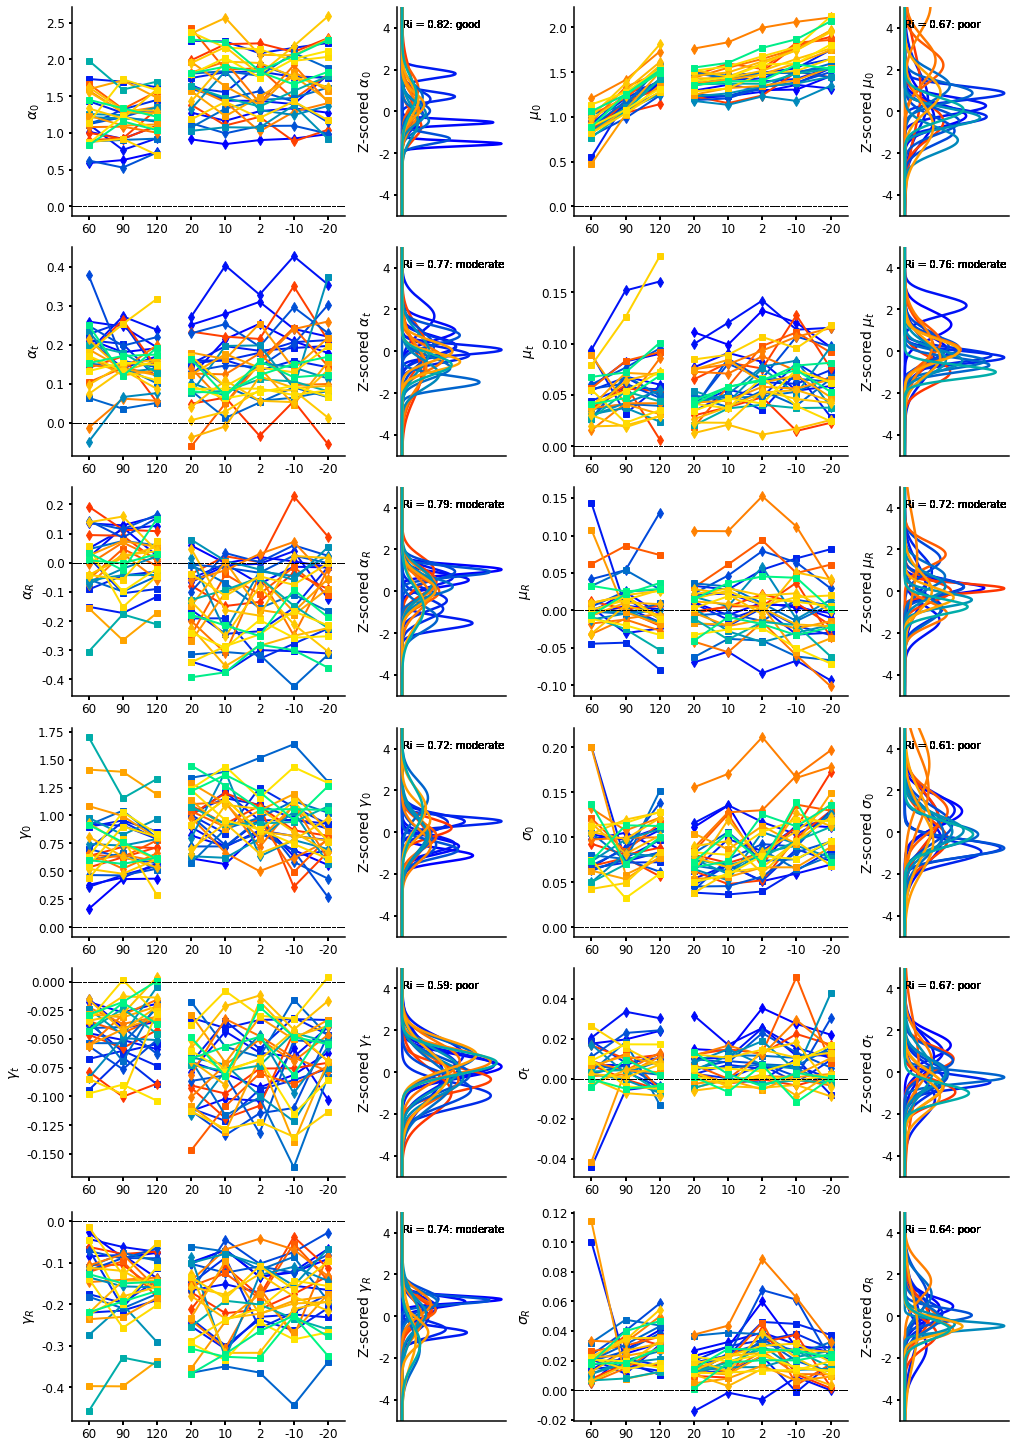

In [30]:
fig, axs = plt.subplots(6, 4, figsize=(14, 20), gridspec_kw={'width_ratios': [5, 2, 5, 2]})
ylabelsIDLE = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_R$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$"]
ylimsIDLE = [[-.5, 3], [-.1, .65], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1]]
ylabelsRUN = [r'$\mu_0$', r"$\mu_t$", r"$\mu_R$", r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_R$"]
ylimsRUN = [[-.2, 2.5], [-.05, .2], [-.15, .15], [-.05, .2], [-.05, .05], [-.025, .1], ]

varsIDLE = [alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]
varsRUN = [mu, mu_t, mu_R, sigma, sigma_t, sigma_R, ]

for animal in animalList:
    for i, (var, ylabel, ylim) in enumerate(zip(varsIDLE, ylabelsIDLE, ylimsIDLE)):
        # x, y = np.arange(8), [var[animal]["60"], var[animal]["90"], var[animal]["120"], var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]]
        axs[i, 0].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].plot([3, 4, 5, 6, 7], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1],
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(8))
        axs[i, 0].set_xticklabels(["60", "90", "120", "20", "10", "2", "-10", "-20"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 7.5)
        # axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(varsRUN, ylabelsRUN, ylimsRUN)):
        axs[i, 2].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 2].plot([3, 4, 5, 6, 7], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1],
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 2].set_title(f"")
        axs[i, 2].set_xticks(np.arange(8))
        axs[i, 2].set_xticklabels(["60", "90", "120", "20", "10", "2", "-10", "-20"])
        axs[i, 2].set_ylabel(ylabel)
        axs[i, 2].set_xlim(-.5, 7.5)
        # axs[i, 2].set_ylim(ylim)
        axs[i, 2].axhline(0, color='black', linestyle='--', linewidth=1)
    

animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43']

intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43']



Zalpha = {animal: {key: (alpha[animal][key] - np.mean([alpha[animal][key] for animal in intact]))/np.std([alpha[animal][key] for animal in intact]) for key in alpha[animal]} for animal in animalList}
Zalpha_t = {animal: {key: (alpha_t[animal][key] - np.mean([alpha_t[animal][key] for animal in intact]))/np.std([alpha_t[animal][key] for animal in intact]) for key in alpha_t[animal]} for animal in animalList}
Zalpha_R = {animal: {key: (alpha_R[animal][key] - np.mean([alpha_R[animal][key] for animal in intact]))/np.std([alpha_R[animal][key] for animal in intact]) for key in alpha_R[animal]} for animal in animalList}
Zgamma = {animal: {key: (gamma[animal][key] - np.mean([gamma[animal][key] for animal in intact]))/np.std([gamma[animal][key] for animal in intact]) for key in gamma[animal]} for animal in animalList}
Zgamma_t = {animal: {key: (gamma_t[animal][key] - np.mean([gamma_t[animal][key] for animal in intact]))/np.std([gamma_t[animal][key] for animal in intact]) for key in gamma_t[animal]} for animal in animalList}
Zgamma_R = {animal: {key: (gamma_R[animal][key] - np.mean([gamma_R[animal][key] for animal in intact]))/np.std([gamma_R[animal][key] for animal in intact]) for key in gamma_R[animal]} for animal in animalList}

traitsIDLE = {animal: [] for animal in animalList}
ZvarsIDLE = [Zalpha, Zalpha_t, Zalpha_R, Zgamma, Zgamma_t, Zgamma_R]
for j, zvar in enumerate(ZvarsIDLE):
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        pdf = stats.norm.pdf(np.linspace(-5, 5, 600), np.mean(zscores), np.std(zscores))
        traitsIDLE[animal].append(np.mean(zscores))
        axs[j, 1].plot(pdf, np.linspace(-5, 5, 600), color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
        Ri = compute_Ri(zvar, intact)
        axs[j, 1].annotate(f'Ri = {Ri:.2f}: {interpret_Ri(Ri)}', xy=(0.05, 0.9), xycoords='axes fraction')
        axs[j, 1].set_ylim(-5, 5)
        axs[j, 1].set_ylabel("Z-scored " + ylabelsIDLE[j])
        axs[j, 1].set_xlabel("")
        axs[j, 1].set_xticks([])



Zmu = {animal: {key: (mu[animal][key] - np.mean([mu[animal][key] for animal in intact]))/np.std([mu[animal][key] for animal in intact]) for key in mu[animal]} for animal in animalList}
Zmu_t = {animal: {key: (mu_t[animal][key] - np.mean([mu_t[animal][key] for animal in intact]))/np.std([mu_t[animal][key] for animal in intact]) for key in mu_t[animal]} for animal in animalList}
Zmu_R = {animal: {key: (mu_R[animal][key] - np.mean([mu_R[animal][key] for animal in intact]))/np.std([mu_R[animal][key] for animal in intact]) for key in mu_R[animal]} for animal in animalList}
Zsigma = {animal: {key: (sigma[animal][key] - np.mean([sigma[animal][key] for animal in intact]))/np.std([sigma[animal][key] for animal in intact]) for key in sigma[animal]} for animal in animalList}
Zsigma_t = {animal: {key: (sigma_t[animal][key] - np.mean([sigma_t[animal][key] for animal in intact]))/np.std([sigma_t[animal][key] for animal in intact]) for key in sigma_t[animal]} for animal in animalList}
Zsigma_R = {animal: {key: (sigma_R[animal][key] - np.mean([sigma_R[animal][key] for animal in intact]))/np.std([sigma_R[animal][key] for animal in intact]) for key in sigma_R[animal]} for animal in animalList}

traitsRUN = {animal: [] for animal in animalList}
ZvarsRUN = [Zmu, Zmu_t, Zmu_R, Zsigma, Zsigma_t, Zsigma_R]
for j, zvar in enumerate(ZvarsRUN):
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        pdf = stats.norm.pdf(np.linspace(-5, 5, 600), np.mean(zscores), np.std(zscores))
        traitsRUN[animal].append(np.mean(zscores))
        axs[j, 3].plot(pdf, np.linspace(-5, 5, 600), color=rat_markers[animal][0], linestyle=rat_markers[animal][2])
        Ri = compute_Ri(zvar, intact)
        axs[j, 3].annotate(f'Ri = {Ri:.2f}: {interpret_Ri(Ri)}', xy=(0.05, 0.9), xycoords='axes fraction')
        axs[j, 3].set_ylim(-5, 5)
        axs[j, 3].set_ylabel("Z-scored " + ylabelsRUN[j])
        axs[j, 3].set_xlabel("")
        axs[j, 3].set_xticks([])

In [31]:

for i in range(len(traitsIDLE[animal])):
    allIntact = []
    allLesion = []
    for animal in animalList:
        if brainstatus[animal] == "normal":
            allIntact.append(traitsIDLE[animal][i])
        else:
            allLesion.append(traitsIDLE[animal][i])
    print(i, exact_mc_perm_test(allIntact, allLesion))



for i in range(len(traitsRUN[animal])):
    allIntact = []
    allLesion = []
    for animal in animalList:
        if brainstatus[animal] == "normal":
            allIntact.append(traitsRUN[animal][i])
        else:
            allLesion.append(traitsRUN[animal][i])
    print(i, exact_mc_perm_test(allIntact, allLesion))

0 0.3681
1 0.2157
2 0.6946
3 0.7495
4 0.9821
5 0.8496
0 0.0207
1 0.9044
2 0.4606
3 0.0442
4 0.4575
5 0.6845


idle 0 0.0297
idle 1 0.0063
idle 2 0.3458
idle 3 0.4935
idle 4 0.9686
idle 5 0.6768
run 0 0.0162
run 1 0.9098
run 2 0.4605
run 3 0.0458
run 4 0.4529
run 5 0.6896


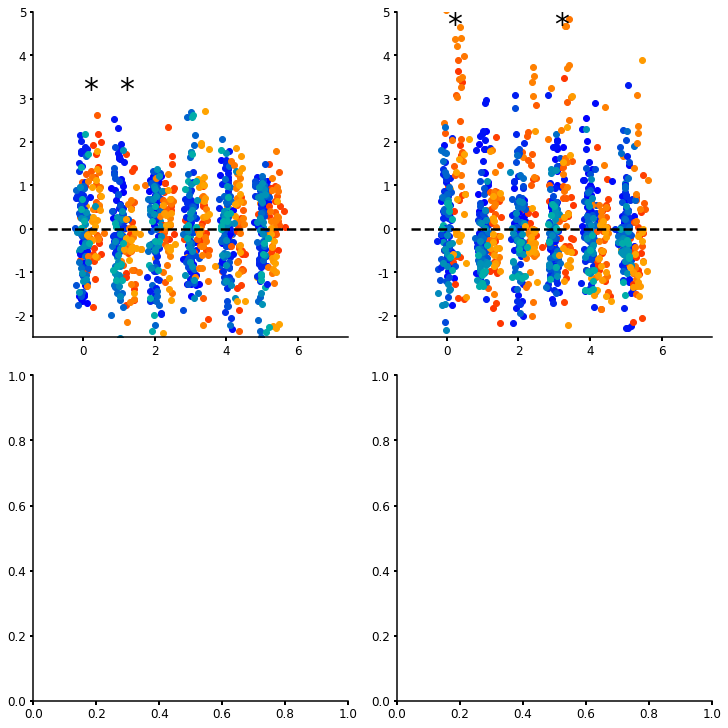

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), )
# for j, zvar in enumerate(traitsIDLE):
for animal in animalList:
    # if 'M' in animal:
    x = np.arange(len(traitsIDLE[animal])) + np.random.normal(0, 0.1, len(traitsIDLE[animal]))
    axs[0, 0].scatter(x, traitsIDLE[animal], color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
    axs[0, 1].scatter(x, traitsRUN[animal], color=rat_markers[animal][0], linestyle=rat_markers[animal][2])

    # else:
        # axs[1, 0].scatter(np.arange(len(traitsIDLE[animal])), traitsIDLE[animal], color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
        # axs[1, 1].scatter(np.arange(len(traitsRUN[animal])), traitsRUN[animal], color=rat_markers[animal][0], linestyle=rat_markers[animal][2])
axs[0, 0].set_ylim(-2.5, 5)
axs[0, 1].set_ylim(-2.5, 5)
axs[0, 0].plot([-1, 7], [0, 0], color='black', linestyle='--')
axs[0, 1].plot([-1, 7], [0, 0], color='black', linestyle='--')




for j, zvar in enumerate(ZvarsIDLE):
    allIntact = []
    allLesion = []
    for animal in animalList:
        
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        # print(animal, zscores)
        if brainstatus[animal] == "normal":
            allIntact.extend(zscores)
            shift=0
        else:
            allLesion.extend(zscores)
            shift=0.35
        x = j+shift+np.random.normal(0, 0.1, len(zscores))
        axs[0, 0].scatter(x, zscores, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
    
    perm = exact_mc_perm_test(allIntact, allLesion)
    print("idle", j, perm)
    if perm < 0.05:
        axs[0, 0].annotate("*", xy=(j, 3), xycoords='data', fontsize=30)

for j, zvar in enumerate(ZvarsRUN):
    allIntact = []
    allLesion = []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        if brainstatus[animal] == "normal":
            allIntact.append(zscores)
            shift=0
        else:
            allLesion.append(zscores)
            shift=0.35
        x = j+shift+np.random.normal(0, 0.1, len(zscores))
        axs[0, 1].scatter(x, zscores, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])

    perm = exact_mc_perm_test(allIntact, allLesion)
    print("run", j, perm)
    if perm < 0.05:
        axs[0, 1].annotate("*", xy=(j, 4.5), xycoords='data', fontsize=30)

idle 0 0.0255
idle 1 0.0056
idle 2 0.3482
idle 3 0.499
idle 4 0.9719
idle 5 0.6816
run 0 0.0157
run 1 0.9109
run 2 0.4705
run 3 0.0458
run 4 0.4569
run 5 0.6915


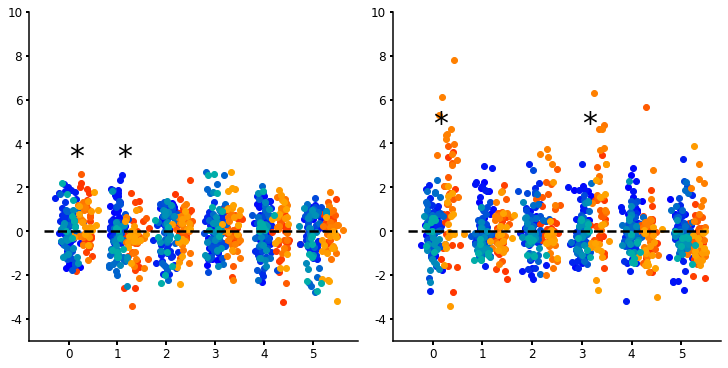

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), )

axs[0].set_ylim(-5, 10)
axs[1].set_ylim(-5, 10)
axs[0].plot([-.5, 5.5], [0, 0], color='black', linestyle='--')
axs[1].plot([-.5, 5.5], [0, 0], color='black', linestyle='--')

for j, zvar in enumerate(ZvarsIDLE):
    allIntact = []
    allLesion = []
    for animal in animalList:
        
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        # print(animal, zscores)
        if brainstatus[animal] == "normal":
            allIntact.extend(zscores)
            shift=0
        else:
            allLesion.extend(zscores)
            shift=0.35
        x = j+shift+np.random.normal(0, 0.1, len(zscores))
        axs[0].scatter(x, zscores, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
    
    perm = exact_mc_perm_test(allIntact, allLesion)
    print("idle", j, perm)
    if perm < 0.05:
        axs[0].annotate("*", xy=(j, 3), xycoords='data', fontsize=30)

for j, zvar in enumerate(ZvarsRUN):
    allIntact = []
    allLesion = []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        if brainstatus[animal] == "normal":
            allIntact.append(zscores)
            shift=0
        else:
            allLesion.append(zscores)
            shift=0.35
        x = j+shift+np.random.normal(0, 0.1, len(zscores))
        axs[1].scatter(x, zscores, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])

    perm = exact_mc_perm_test(allIntact, allLesion)
    print("run", j, perm)
    if perm < 0.05:
        axs[1].annotate("*", xy=(j, 4.5), xycoords='data', fontsize=30)


In [ ]:
intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF32', 'RatF33', 'RatM31', 'RatM32', 
              'RatF42', 'RatM40', 'RatM43'
              ]

$\alpha_0$ corr: 0.56, p: 0.0487
$\alpha_t$ corr: -0.67, p: 0.0119
$\alpha_R$ corr: -0.75, p: 0.0033
$\gamma_0$ corr: 0.81, p: 0.0007
$\gamma_t$ corr: 0.21, p: 0.4839
$\gamma_R$ corr: -0.71, p: 0.0061
$\mu_0$ corr: 0.59, p: 0.0340
$\mu_t$ corr: -0.67, p: 0.0115
$\mu_R$ corr: -0.01, p: 0.9625
$\sigma_0$ corr: -0.43, p: 0.1376
$\sigma_t$ corr: -0.61, p: 0.0257
$\sigma_R$ corr: 0.23, p: 0.4422


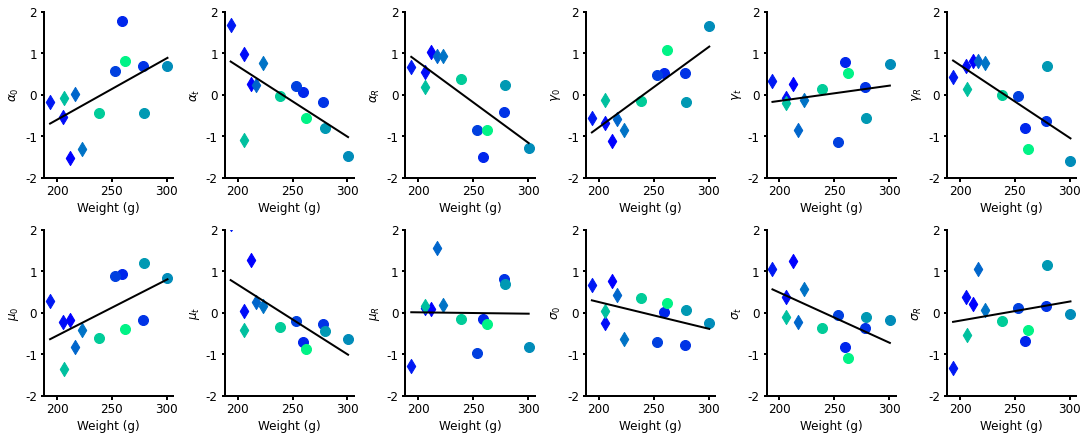

In [ ]:
weights = {'RatF00': 212.02, 'RatF01': 205.85, 'RatF02': 193.75,
            'RatM00': 259.37, 'RatM01': 278.12, 'RatM02': 253.19,
            # 'RatF20': 220.10, 'RatF21': 215.53, 'RatF22': 215.0,
            # 'RatM20': 254.68, 'RatM21': 307.29, 'RatM22': 330.53,
            'RatF30': 217.32, 'RatF31': 228.95, 'RatF32': 216.80, 'RatF33': 222.77,
            'RatM30': 261.38, 'RatM31': 300.55, 'RatM32': 279.23, 
            # 'RatF30L': 217.32, 'RatF31L': 228.95, 'RatF32L': 216.80, 'RatF33L': 222.77,
            # 'RatM30L': 261.38, 'RatM31L': 300.55, 'RatM32L': 279.23
            'RatF40': 196.85, 'RatF41': 199.24, 'RatF42': 206.02,
            'RatM40': 238.70, 'RatM41': 238.19, 'RatM42': 242.87, 'RatM43': 262.23}

fig, ax = plt.subplots(2, 6, figsize=(15, 6))
for j, zvar in enumerate(ZvarsIDLE):
    _x, _y = [], []
    for animal in intact:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        y = np.mean(zscores)
        x = weights[animal]

        ax[0, j].scatter(x, y, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
        ax[0, j].set_xlabel("Weight (g)")
        ax[0, j].set_ylabel(ylabelsIDLE[j])
        ax[0, j].set_ylim(-2, 2)

        _x.append(x)
        _y.append(y)

    pearson = stats.pearsonr(_x, _y)
    print(ylabelsIDLE[j]+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
    ax[0, j].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)

for j, zvar in enumerate(ZvarsRUN):
    _x, _y = [], []
    for animal in intact:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        y = np.mean(zscores)
        x = weights[animal]

        ax[1, j].scatter(x, y, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
        ax[1, j].set_xlabel("Weight (g)")
        ax[1, j].set_ylabel(ylabelsRUN[j])
        ax[1, j].set_ylim(-2, 2)

        _x.append(x)
        _y.append(y)

    pearson = stats.pearsonr(_x, _y)
    print(ylabelsRUN[j]+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
    ax[1, j].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)

In [ ]:
_map = plt.cm.get_cmap('jet')

for index, animal in enumerate(animalList):

    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[_map(index/len(animalList)), 'd', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[_map(index/len(animalList)), 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF32
Loading data for RatF33
Loading data for RatM31
Loading data for RatM32


# behav

$\alpha_0$: 0.001
$\alpha_t$: 0.000
$\alpha_R$: 0.843
$\gamma_0$: 0.930
$\gamma_t$: 0.729
$\gamma_R$: 0.899
$\mu_0$: 0.0
$\mu_t$: 0.0687
$\mu_R$: 0.1581
$\sigma_0$: 0.0071
$\sigma_t$: 0.0544
$\sigma_R$: 0.123


(-6.0, 6.0)

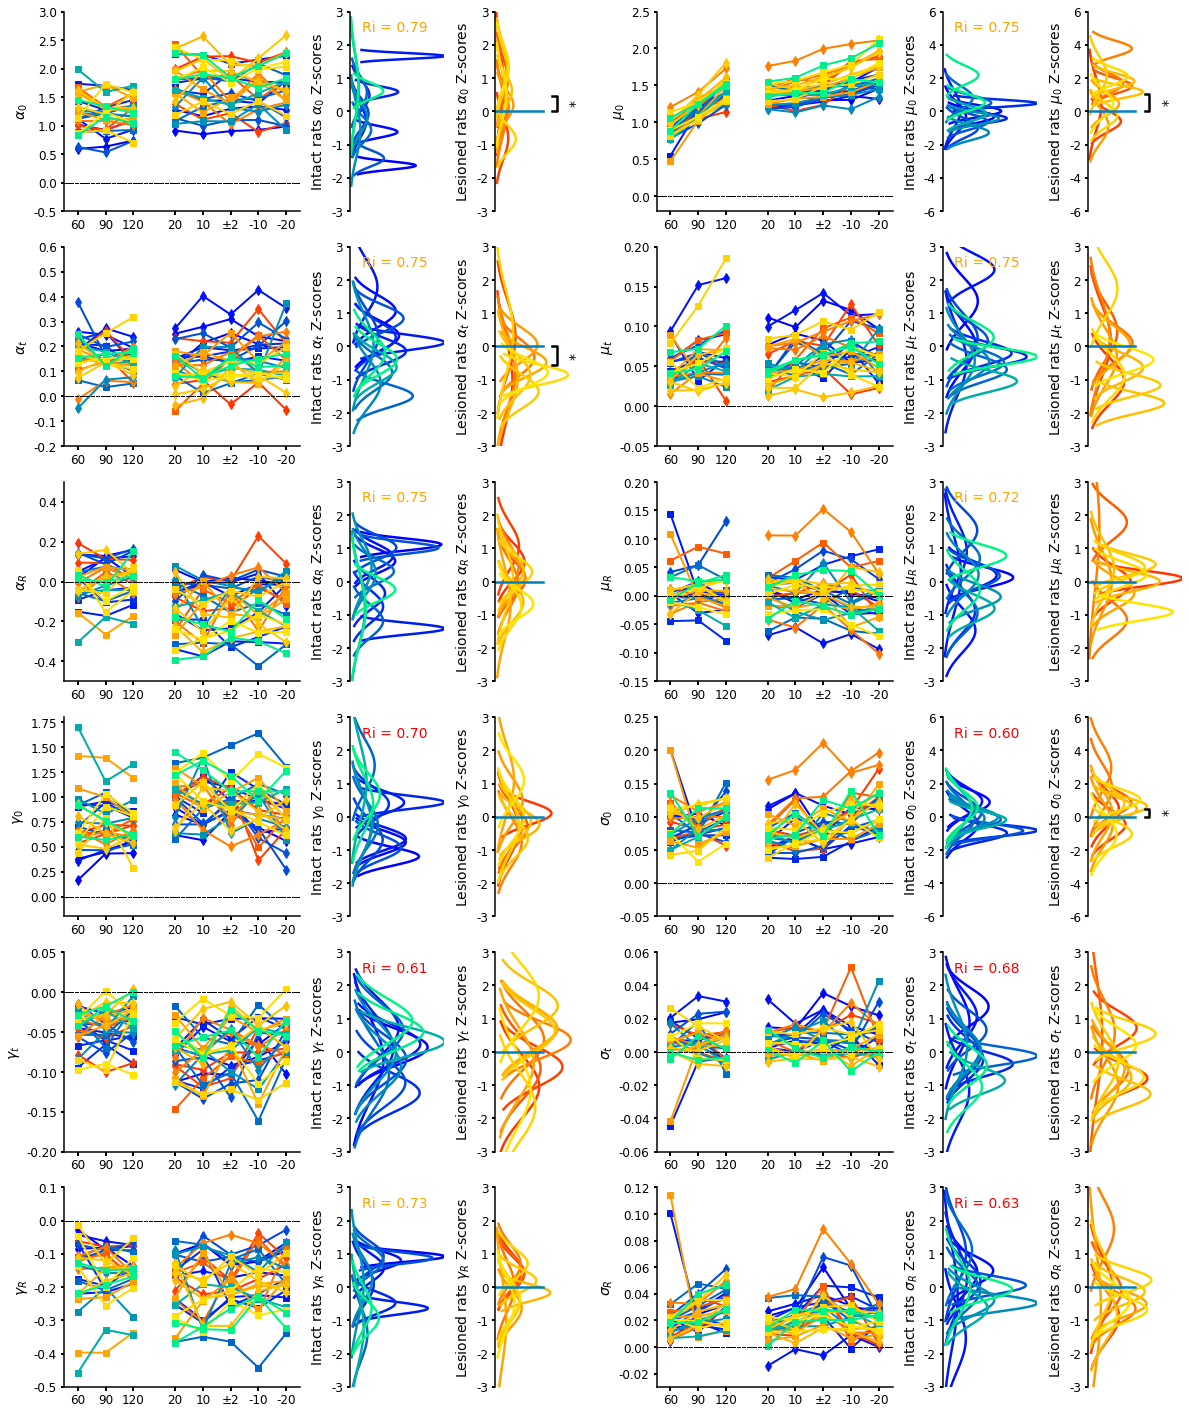

In [34]:
fig, axs = plt.subplots(6, 6, figsize=(42/2.56, 50/2.56), gridspec_kw={'width_ratios': [5, 2, 2, 5, 2, 2]}, constrained_layout=True)
ylabelsIDLE = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_R$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$"]
ylimsIDLE = [[-.5, 3], [-.2, .6], [-.5, .5], [-.2, 1.8], [-.2, .05], [-.5, .1]]
ylabelsRUN = [r'$\mu_0$', r"$\mu_t$", r"$\mu_R$", r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_R$"]
ylimsRUN = [[-.2, 2.5], [-.05, .2], [-.15, .2], [-.05, .25], [-.06, .06], [-.03, .12], ]

varsIDLE = [alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]
varsRUN = [mu, mu_t, mu_R, sigma, sigma_t, sigma_R, ]


animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 'RatM53', 'RatM54']

for animal in animalList:
    for i, (var, ylabel, ylim) in enumerate(zip(varsIDLE, ylabelsIDLE, ylimsIDLE)):
        # x, y = np.arange(8), [var[animal]["60"], var[animal]["90"], var[animal]["120"], var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]]
        axs[i, 0].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].plot([3.5, 4.5, 5.5, 6.5, 7.5], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1],
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks([0, 1, 2, 3.5, 4.5, 5.5, 6.5, 7.5])
        axs[i, 0].set_xticklabels(["60", "90", "120", "20", "10", "±2", "-10", "-20"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 8)
        axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(varsRUN, ylabelsRUN, ylimsRUN)):
        axs[i, 3].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 3].plot([3.5, 4.5, 5.5, 6.5, 7.5], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1],
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 3].set_title(f"")
        axs[i, 3].set_xticks([0, 1, 2, 3.5, 4.5, 5.5, 6.5, 7.5])
        axs[i, 3].set_xticklabels(["60", "90", "120", "20", "10", "±2", "-10", "-20"])
        axs[i, 3].set_ylabel(ylabel)
        axs[i, 3].set_xlim(-.5, 8)
        axs[i, 3].set_ylim(ylim)
        axs[i, 3].axhline(0, color='black', linestyle='--', linewidth=1)
    





Zalpha = {animal: {key: (alpha[animal][key] - np.mean([alpha[animal][key] for animal in intact]))/np.std([alpha[animal][key] for animal in intact]) for key in alpha[animal]} for animal in animalList}
Zalpha_t = {animal: {key: (alpha_t[animal][key] - np.mean([alpha_t[animal][key] for animal in intact]))/np.std([alpha_t[animal][key] for animal in intact]) for key in alpha_t[animal]} for animal in animalList}
Zalpha_R = {animal: {key: (alpha_R[animal][key] - np.mean([alpha_R[animal][key] for animal in intact]))/np.std([alpha_R[animal][key] for animal in intact]) for key in alpha_R[animal]} for animal in animalList}
Zgamma = {animal: {key: (gamma[animal][key] - np.mean([gamma[animal][key] for animal in intact]))/np.std([gamma[animal][key] for animal in intact]) for key in gamma[animal]} for animal in animalList}
Zgamma_t = {animal: {key: (gamma_t[animal][key] - np.mean([gamma_t[animal][key] for animal in intact]))/np.std([gamma_t[animal][key] for animal in intact]) for key in gamma_t[animal]} for animal in animalList}
Zgamma_R = {animal: {key: (gamma_R[animal][key] - np.mean([gamma_R[animal][key] for animal in intact]))/np.std([gamma_R[animal][key] for animal in intact]) for key in gamma_R[animal]} for animal in animalList}

traitsIDLE = {animal: [] for animal in animalList}
ZvarsIDLE = [Zalpha, Zalpha_t, Zalpha_R, Zgamma, Zgamma_t, Zgamma_R]
for j, zvar in enumerate(ZvarsIDLE):
    xmin, xmax = 0, 0
    ymax = 0
    allIntact = []
    allLesion = []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        xx = np.linspace(stats.norm.ppf(0.02, loc=np.mean(zscores), scale=np.std(zscores)), stats.norm.ppf(.98, loc=np.mean(zscores), scale=np.std(zscores)), 100)
        if min(xx) < xmin:
            xmin = min(xx)
        if max(xx) > xmax:
            xmax = max(xx)
        pdf = stats.norm.pdf(xx, np.mean(zscores), np.std(zscores))
        if max(pdf) > ymax:
            ymax = max(pdf)
        traitsIDLE[animal].append(np.mean(zscores))
        if brainstatus[animal] == "normal":
            axs[j, 1].plot(pdf, xx, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
            allIntact.extend(zscores)
        else:
            axs[j, 2].plot(pdf, xx, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
            allLesion.extend(zscores)
    
    Ri = compute_Ri(zvar, intact)
    axs[j, 1].annotate(f'Ri = {Ri:.2f}', xy=(0.125, 0.9), xycoords='axes fraction', color=Ri_color(Ri), fontsize=14, )

    allIntact = np.array(allIntact).flatten()
    allLesion = np.array(allLesion).flatten()
    perm = exact_mc_perm_test(allIntact, allLesion)
    print(f"{ylabelsIDLE[j]}: {perm:.3f}")
    if perm < 0.05:
        intact_vs_lesion_Zscore(axs[j, 2], 0, 1, perm, 
                                    [0, np.mean([traitsIDLE[animal][j] for animal in animalList if brainstatus[animal] != 'normal'])], 
                                    [ymax/2, ymax/2], yerr=None, dh=ymax/10, barh=ymax/20, fs=14, maxasterix=1)

    # axs[j, 1].set_ylim(xmin, xmax)
    axs[j, 1].set_ylim(-3, 3)
    axs[j, 1].set_xlim(0, ymax)
    axs[j, 1].set_ylabel(f"Intact rats {ylabelsIDLE[j]} Z-scores")
    axs[j, 1].set_xlabel("")
    axs[j, 1].set_xticks([])
    axs[j, 1].spines['bottom'].set_visible(False)
    axs[j, 2].set_ylim(xmin, xmax)
    axs[j, 2].plot([0, ymax/2], [0, 0], c=plt.cm.get_cmap('winter')(.5))
    axs[j, 2].set_ylim(-3, 3)
    axs[j, 2].set_xlim(0, ymax)
    axs[j, 2].set_ylabel(f"Lesioned rats {ylabelsIDLE[j]} Z-scores")
    axs[j, 2].set_xlabel("")
    axs[j, 2].set_xticks([])
    axs[j, 2].spines['bottom'].set_visible(False)



Zmu = {animal: {key: (mu[animal][key] - np.mean([mu[animal][key] for animal in intact]))/np.std([mu[animal][key] for animal in intact]) for key in mu[animal]} for animal in animalList}
Zmu_t = {animal: {key: (mu_t[animal][key] - np.mean([mu_t[animal][key] for animal in intact]))/np.std([mu_t[animal][key] for animal in intact]) for key in mu_t[animal]} for animal in animalList}
Zmu_R = {animal: {key: (mu_R[animal][key] - np.mean([mu_R[animal][key] for animal in intact]))/np.std([mu_R[animal][key] for animal in intact]) for key in mu_R[animal]} for animal in animalList}
Zsigma = {animal: {key: (sigma[animal][key] - np.mean([sigma[animal][key] for animal in intact]))/np.std([sigma[animal][key] for animal in intact]) for key in sigma[animal]} for animal in animalList}
Zsigma_t = {animal: {key: (sigma_t[animal][key] - np.mean([sigma_t[animal][key] for animal in intact]))/np.std([sigma_t[animal][key] for animal in intact]) for key in sigma_t[animal]} for animal in animalList}
Zsigma_R = {animal: {key: (sigma_R[animal][key] - np.mean([sigma_R[animal][key] for animal in intact]))/np.std([sigma_R[animal][key] for animal in intact]) for key in sigma_R[animal]} for animal in animalList}

traitsRUN = {animal: [] for animal in animalList}
ZvarsRUN = [Zmu, Zmu_t, Zmu_R, Zsigma, Zsigma_t, Zsigma_R]
for j, zvar in enumerate(ZvarsRUN):
    xmin, xmax = 0, 0
    ymax = 0
    allIntact = []
    allLesion = []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        xx = np.linspace(stats.norm.ppf(0.02, loc=np.mean(zscores), scale=np.std(zscores)), stats.norm.ppf(.98, loc=np.mean(zscores), scale=np.std(zscores)), 100)
        if min(xx) < xmin:
            xmin = min(xx)
        if max(xx) > xmax:
            xmax = max(xx)
        pdf = stats.norm.pdf(xx, np.mean(zscores), np.std(zscores))
        if max(pdf) > ymax:
            ymax = max(pdf)
        traitsRUN[animal].append(np.mean(zscores))

        if brainstatus[animal] == "normal":
            axs[j, 4].plot(pdf, xx, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
            allIntact.extend(zscores)
        else:
            axs[j, 5].plot(pdf, xx, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
            allLesion.extend(zscores)
    
    Ri = compute_Ri(zvar, intact)
    axs[j, 4].annotate(f'Ri = {Ri:.2f}', xy=(0.125, 0.9), xycoords='axes fraction', color=Ri_color(Ri), fontsize=14, )

    allIntact = np.array(allIntact).flatten()
    allLesion = np.array(allLesion).flatten()
    perm = exact_mc_perm_test(allIntact, allLesion)
    print(f"{ylabelsRUN[j]}: {perm}")
    if perm < 0.05:
        intact_vs_lesion_Zscore(axs[j, 5], 0, 1, perm, 
                                    [0, np.mean([traitsRUN[animal][j] for animal in animalList if brainstatus[animal] != 'normal'])], 
                                    [ymax/2, ymax/2], yerr=None, dh=ymax/10, barh=ymax/20, fs=14, maxasterix=1)



    # axs[j, 4].set_ylim(xmin, xmax)
    axs[j, 4].set_ylim(-3, 3)
    axs[j, 4].set_xlim(0, ymax)

    axs[j, 4].set_ylabel(f"Intact rats {ylabelsRUN[j]} Z-scores")
    axs[j, 4].set_xlabel("")
    axs[j, 4].set_xticks([])
    axs[j, 4].spines['bottom'].set_visible(False)
    # axs[j, 5].set_ylim(xmin, xmax)
    axs[j, 5].set_ylim(-3, 3)
    axs[j, 5].set_xlim(0, ymax)
    axs[j, 5].plot([0, ymax/2], [0, 0], c=plt.cm.get_cmap('winter')(.5))
    axs[j, 5].set_ylabel(f"Lesioned rats {ylabelsRUN[j]} Z-scores")
    axs[j, 5].set_xlabel("")
    axs[j, 5].set_xticks([])
    axs[j, 5].spines['bottom'].set_visible(False)


axs[0, 4].set_ylim(-6, 6)
axs[0, 5].set_ylim(-6, 6)

axs[3, 4].set_ylim(-6, 6)
axs[3, 5].set_ylim(-6, 6)

# save_plot_as_png('/media/david/DAA6-6D9D/iBAGS/FitVariaComp.png', dpi=300, transparent=True, background='auto')

idle 0 0.0005 -1.8041124150158794e-17 0.4556541810061056
idle 1 0.0001 1.4224732503009817e-17 -0.5724760073618217
idle 2 0.8444 -2.701831813833877e-17 0.024621138423774506
idle 3 0.9383 -9.113080660464826e-17 -0.010903338909744358
idle 4 0.728 5.66676335485757e-17 0.053376951665909396
idle 5 0.898 -2.983724378680108e-17 -0.015466420369624735
run 0 0.0 8.548428169034376e-16 1.0660029690201158
run 1 0.0698 5.955883934187037e-18 -0.2583593671815514
run 2 0.1441 -1.2490009027033011e-17 0.2002769190641713
run 3 0.0061 1.1356656356061497e-16 0.4753063014432861
run 4 0.0563 3.14563190310461e-17 -0.26269198094378204
run 5 0.1133 6.214646852686912e-17 -0.21624724986371333


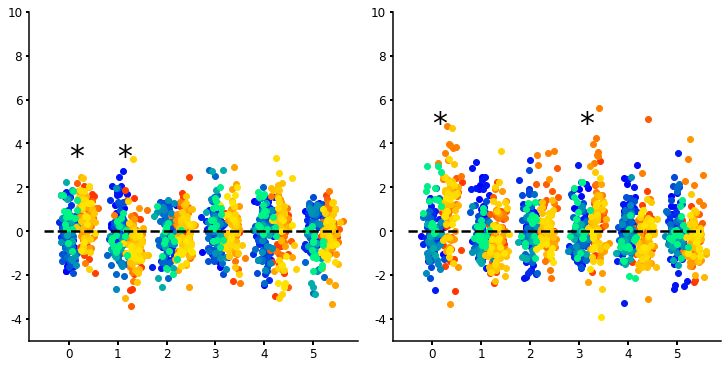

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), )

axs[0].set_ylim(-5, 10)
axs[1].set_ylim(-5, 10)
axs[0].plot([-.5, 5.5], [0, 0], color='black', linestyle='--')
axs[1].plot([-.5, 5.5], [0, 0], color='black', linestyle='--')

for j, zvar in enumerate(ZvarsIDLE):
    allIntact = []
    allLesion = []
    for animal in animalList:
        
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        # print(animal, zscores)
        if brainstatus[animal] == "normal":
            allIntact.extend(zscores)
            shift=0
        else:
            allLesion.extend(zscores)
            shift=0.35
        x = j+shift+np.random.normal(0, 0.1, len(zscores))
        axs[0].scatter(x, zscores, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
    
    perm = exact_mc_perm_test(allIntact, allLesion)
    print("idle", j, perm, np.mean(allIntact), np.mean(allLesion))
    if perm < 0.05:
        axs[0].annotate("*", xy=(j, 3), xycoords='data', fontsize=30)

for j, zvar in enumerate(ZvarsRUN):
    allIntact = []
    allLesion = []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        if brainstatus[animal] == "normal":
            allIntact.append(zscores)
            shift=0
        else:
            allLesion.append(zscores)
            shift=0.35
        x = j+shift+np.random.normal(0, 0.1, len(zscores))
        axs[1].scatter(x, zscores, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])

    allIntact = np.array(allIntact).flatten()
    allLesion = np.array(allLesion).flatten()
    perm = exact_mc_perm_test(allIntact, allLesion)
    print("run", j, perm, np.mean(allIntact), np.mean(allLesion))
    if perm < 0.05:
        axs[1].annotate("*", xy=(j, 4.5), xycoords='data', fontsize=30)


In [10]:
realdist60 = {}
realdist90 = {}
realdist120= {}


# compute the running distance for each run (pos start - pos end) for each distance configuration
for animal in animalList:
    realdist60[animal], realdist90[animal], realdist120[animal] = ([] for _ in range(3))
    for session in sorted(matchsession(animal, dist60)):
        for i in range(0, 12):
            realdist60[animal] = np.append(realdist60[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist60[animal] = np.append(realdist60[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist90)):   
        for i in range(0, 12):
            realdist90[animal] = np.append(realdist90[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist90[animal] = np.append(realdist90[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist120)):
        for i in range(0, 12):
            realdist120[animal] = np.append(realdist120[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist120[animal] = np.append(realdist120[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])

# compute the mean running distance for each animal for each distance configuration
medianrealdist60 = {}
medianrealdist90 = {}
medianrealdist120 = {}

for animal in animalList:
    medianrealdist60[animal] = np.median(realdist60[animal]) / 100
    medianrealdist90[animal] = np.median(realdist90[animal]) / 100
    medianrealdist120[animal] = np.median(realdist120[animal]) / 100



In [11]:
def T_opt(D, vbelt, epsilon):
    det = np.sqrt(epsilon**2 * vbelt**4 + 12*epsilon*D**2)
    Tsq = ((det - (epsilon * vbelt**2)) / 6)
    return np.sqrt(Tsq)

In [9]:
def effort_loss(params, *args):

    epsilon_0, epsilon_t, epsilon_R = params
    fit_params, realdist, N_bins, N_avg = args
    mu_0, mu_t, mu_R = fit_params
    S, M, L = realdist

    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]
    params_distance = {"60": S, "90": M, "120": L, "20": L, "10": L, "2": L, "rev10": L, "rev20": L}
    params_vbelt = {"60": 0, "90": 0, "120": 0, "20": .2, "10": .1, "2": .02, "rev10": -.1, "rev20": -.2}

    loss = 0
    MU = {key: np.zeros((N_bins, N_avg)) for key in conds}
    EPSILON = np.zeros((N_bins, N_avg))

    for cond in conds:
        for bin in range(N_bins):
            for avg in range(N_avg):
                MU[cond][bin, avg] = mu_0[cond] + bin*mu_t[cond] + avg*mu_R[cond]
                EPSILON[bin, avg] = epsilon_0 + bin*epsilon_t + avg*epsilon_R

    for bin in range(N_bins):
        for avg in range(N_avg):
            # if bin == 0 and avg == 0:
                experimental_data = [MU[cond][bin, avg] for cond in conds]
                theoretical_data = [T_opt(params_distance[cond], params_vbelt[cond], epsilon=EPSILON[bin, avg]) for cond in conds]
                loss += np.sum((np.array(experimental_data) - np.array(theoretical_data))**2)

    return loss

def effort_fit(mu_0, mu_t, mu_R, 
                realdist60, realdist90, realdist120, 
                init=[12, 5, 0], 
                f=effort_loss, N_bins=6, N_avg=4):
    
    params_init = np.array(init)

    res = minimize(f, params_init, 
                    args=((mu_0, mu_t, mu_R), (realdist60, realdist90, realdist120, ), N_bins, N_avg),
                    method='nelder-mead', options={'xatol': 1e-9})
    return res.x, res.fun

animal = 'RatF01'
effort_fit(mu[animal], mu_t[animal], mu_R[animal], medianrealdist60[animal], medianrealdist90[animal], medianrealdist120[animal])

(array([10.26810017,  3.40205765,  0.32727476]), 1.3876304774765926)

In [55]:
def T_opt(D, vbelt, epsilon, power_effort, power_time=3):
    'dirty find optimal time for a given distance, belt speed, and reward size'
    T = np.linspace(0.0, 2.5, 1000)
    vmax = (D - vbelt * T) / (T)
    cost = epsilon * T * vmax ** power_effort + T**power_time
    Topt = T[np.nanargmin(cost)]
    return Topt

def effort_loss(params, *args):

    epsilon_0, epsilon_t, epsilon_R, power_0 = params
    fit_params, realdist, N_bins, N_avg = args
    mu_0, mu_t, mu_R = fit_params
    S, M, L = realdist

    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]
    params_distance = {"60": S, "90": M, "120": L, "20": L, "10": L, "2": L, "rev10": L, "rev20": L}
    params_vbelt = {"60": 0, "90": 0, "120": 0, "20": .2, "10": .1, "2": .02, "rev10": -.1, "rev20": -.2}

    loss = 0
    MU = {key: np.zeros((N_bins, N_avg)) for key in conds}
    EPSILON = np.zeros((N_bins, N_avg))
    POWER = np.zeros((N_bins, N_avg))

    for cond in conds:
        for bin in range(N_bins):
            for avg in range(N_avg):
                MU[cond][bin, avg] = mu_0[cond] + bin*mu_t[cond] + avg*mu_R[cond]
                EPSILON[bin, avg] = epsilon_0 + bin*epsilon_t + avg*epsilon_R
                POWER[bin, avg] = power_0

    for bin in range(N_bins):
        for avg in range(N_avg):
            # if bin == 0 and avg == 0:
                experimental_data = [MU[cond][bin, avg] for cond in conds]
                theoretical_data = [T_opt(params_distance[cond], params_vbelt[cond], epsilon=EPSILON[bin, avg], power_effort=POWER[bin, avg]) for cond in conds]
                loss += np.sum((np.array(experimental_data) - np.array(theoretical_data))**2)

    return loss

def effort_fit(mu_0, mu_t, mu_R, 
                realdist60, realdist90, realdist120, 
                init=[12, 5, 1, 3], 
                f=effort_loss, N_bins=6, N_avg=4):
    
    params_init = np.array(init)

    res = minimize(f, params_init, 
                    args=((mu_0, mu_t, mu_R), (realdist60, realdist90, realdist120, ), N_bins, N_avg),
                    method='nelder-mead', options={'xatol': 1e-9}, 
                    # bounds=[(0, 75), (-5, 15), (-5, 12), (-6, 6)]
                    )
    return res.x, res.fun

animal = 'RatF01'
effort_fit(mu[animal], mu_t[animal], mu_R[animal], medianrealdist60[animal], medianrealdist90[animal], medianrealdist120[animal])

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


(array([10.49368857,  5.08680621,  1.0471249 ,  1.85417129]),
 2.513126686540844)

In [54]:
animal = 'RatM30'
mu[animal], mu_t[animal], mu_R[animal], medianrealdist60[animal], medianrealdist90[animal], medianrealdist120[animal]

({'60': 1.0539286063077338,
  '90': 1.1851905119721655,
  '120': 1.5167136111870922,
  '20': 1.342952416204213,
  '10': 1.6350237766443498,
  '2': 1.5138574678089505,
  'rev10': 1.801634097899364,
  'rev20': 1.8426190838986902},
 {'60': 0.05042855666951958,
  '90': 0.0948571313849369,
  '120': 0.09171442272611754,
  '20': 0.05828570291902406,
  '10': 0.049857142245863656,
  '2': 0.10885710553514043,
  'rev10': 0.1785337451756285,
  'rev20': 0.09628570354434737},
 {'60': 0.061666665515726166,
  '90': 0.11399999199526598,
  '120': 0.09266678848201573,
  '20': 0.0786666587999947,
  '10': 0.06300001141493415,
  '2': 0.1259998720410499,
  'rev10': 0.018880579981111274,
  'rev20': 0.06999999023511168},
 0.3133281294532828,
 0.6343440353041142,
 0.9505367480181462)

In [56]:
epsilon_0 = {}
epsilon_t = {}
epsilon_R = {}
power_0 = {}
loss_effort_fit = {}

for animal in animalList:
    (epsilon_0[animal], epsilon_t[animal], epsilon_R[animal], power_0[animal]), loss_effort_fit[animal] = effort_fit(mu[animal], mu_t[animal], mu_R[animal], medianrealdist60[animal], medianrealdist90[animal], medianrealdist120[animal])
    print(animal, epsilon_0[animal], epsilon_t[animal], epsilon_R[animal], power_0[animal], loss_effort_fit[animal])

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


RatF00 9.129147344004695 7.362914371881901 0.9647471196330376 2.181978270870748 1.7331128276835022
RatF01 10.493688567396411 5.086806206468955 1.0471249027424372 1.854171292721318 2.513126686540844
RatF02 9.34748697634718 7.956656798936822 0.8252935202169414 2.0670400865798197 3.216682475212351
RatM00 12.515174069929198 3.1000976288386535 1.1648655467155336 2.44273950770834 1.7211918582151422
RatM01 7.473861067037911 3.754610783293992 3.7538912805994924 3.012499408424335 1.9942528847482588
RatM02 13.15574938098067 3.4596857013180013 -1.2485721091372715 2.659833300995682 2.4250963740484854
RatF30 17.007936081508987 2.690782081617335 1.069563186048729 3.1149074989951666 5.908138149989004
RatF31 7.010040376235786 4.223236227975685 1.218354144009712 2.740309579112747 6.48732217183825
RatF32 4.938369835685486 4.880805130174649 4.644547517819818 3.062083173046873 2.6867646186262855
RatF33 6.454421806173844 3.972261054081941 1.5134024241449016 2.4791837401573105 1.804661803899174
RatM30 28.71

In [10]:
epsilon_0 = {}
epsilon_t = {}
epsilon_R = {}
loss_effort_fit = {}

for animal in animalList:
    (epsilon_0[animal], epsilon_t[animal], epsilon_R[animal]), loss_effort_fit[animal] = effort_fit(mu[animal], mu_t[animal], mu_R[animal], medianrealdist60[animal], medianrealdist90[animal], medianrealdist120[animal])
    print(animal, epsilon_0[animal], epsilon_t[animal], epsilon_R[animal], loss_effort_fit[animal])

RatF00 10.666624655814768 6.208084908836739 0.2056948312355601 0.7160104660153984
RatF01 10.268100169720539 3.402057650802255 0.32727475827556396 1.3876304774765926
RatF02 13.88632677062273 7.637494221050936 -2.6550888361269616 2.2888333020813363
RatM00 15.881763883665764 2.9646615882412455 0.05567015402688983 3.2426185064243525
RatM01 11.483917145135276 3.3087693128458877 2.0424137298114458 4.041809702569095
RatM02 16.406724585301887 3.273195509897169 -1.6753754792061317 3.514804417421811
RatF30 18.90156150166412 2.49472212088463 0.2809201673484527 8.025207329430806
RatF31 10.921724212105214 3.553272896594338 -0.06711416203736406 6.615218939615549
RatF32 8.372752109769877 3.927619115747495 3.2154251920939734 4.588578005709333
RatF33 9.946034321564191 3.4329222424253407 0.30107460535382824 2.6534979265596808
RatM30 20.890112584294805 8.132972647765875 6.52306671049842 7.7690680567887735
RatM31 16.643203741008115 2.4423698276917154 -1.8111987466004986 0.7104928606178811
RatM32 16.639971

In [57]:
# pickle.dump((epsilon_0, epsilon_t, epsilon_R), open('picklejar/effort_fit.p', 'wb'))
pickle.dump((epsilon_0, epsilon_t, epsilon_R, power_0), open('picklejar/effort_fit.p', 'wb'))
# epsilon_0, epsilon_t, epsilon_R = pickle.load(open('picklejar/effort_fit.p', 'rb'))

9.129147344004695 7.362914371881901 0.9647471196330376
10.493688567396411 5.086806206468955 1.0471249027424372
9.34748697634718 7.956656798936822 0.8252935202169414
12.515174069929198 3.1000976288386535 1.1648655467155336
7.473861067037911 3.754610783293992 3.7538912805994924
13.15574938098067 3.4596857013180013 -1.2485721091372715
17.007936081508987 2.690782081617335 1.069563186048729
7.010040376235786 4.223236227975685 1.218354144009712
4.938369835685486 4.880805130174649 4.644547517819818
6.454421806173844 3.972261054081941 1.5134024241449016
28.713431201112527 12.041999627328343 0.4941179696371478
12.897890725638188 2.6294749618966646 1.0721013097726158
13.656376143137969 5.69687775200507 1.0704958390155292
22.562970441203525 5.942568476613496 -3.206825158660875
36.130565531754264 14.88973070026671 12.577079091104752
6.118809451513054 1.9944815716182922 1.683645286999088
5.835144572507901 3.2087884914319806 1.429946363822636
9.290117126608411 2.323936777971984 -0.47095556497304036


Text(0.5, 0, 'effort sensibility parameter')

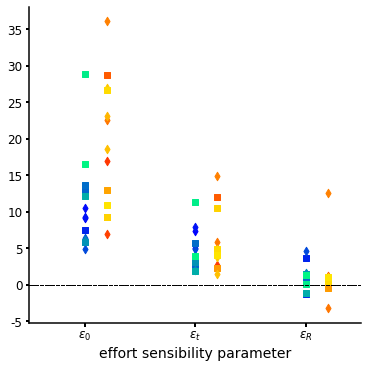

In [58]:
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 'RatM53', 'RatM54']

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
ylabels = [r'$\epsilon_0$', r"$\epsilon_t$", r"$\epsilon_R$"]
ylims = [[-.2, 2.5], [-.05, .2], [-.15, .15],]


epsilon_0_intact = []
epsilon_t_intact = []
epsilon_R_intact = []

epsilon_0_lesion = []
epsilon_t_lesion = []
epsilon_R_lesion = []

for animal in animalList:
    if animal in intact:
        x = np.arange(3)
        epsilon_0_intact.append(epsilon_0[animal])
        epsilon_t_intact.append(epsilon_t[animal])
        epsilon_R_intact.append(epsilon_R[animal])

    else:
        x = np.arange(3) + .2
        epsilon_0_lesion.append(epsilon_0[animal])
        epsilon_t_lesion.append(epsilon_t[animal])
        epsilon_R_lesion.append(epsilon_R[animal])

    print(epsilon_0[animal], epsilon_t[animal], epsilon_R[animal])
    axs.scatter(x,  [epsilon_0[animal], epsilon_t[animal], epsilon_R[animal]], color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1])
    axs.set_title(f"")
    axs.set_xticks(np.arange(3))
    axs.set_xticklabels(ylabels)
    axs.set_xlim(-.5, 2.5)
    # axs.set_ylim(ylim)
    axs.axhline(0, color='black', linestyle='--', linewidth=1)

axs.set_xlabel("effort sensibility parameter")



9.129147344004695 7.362914371881901 0.9647471196330376
10.493688567396411 5.086806206468955 1.0471249027424372
9.34748697634718 7.956656798936822 0.8252935202169414
12.515174069929198 3.1000976288386535 1.1648655467155336
7.473861067037911 3.754610783293992 3.7538912805994924
13.15574938098067 3.4596857013180013 -1.2485721091372715
17.007936081508987 2.690782081617335 1.069563186048729
7.010040376235786 4.223236227975685 1.218354144009712
4.938369835685486 4.880805130174649 4.644547517819818
6.454421806173844 3.972261054081941 1.5134024241449016
28.713431201112527 12.041999627328343 0.4941179696371478
12.897890725638188 2.6294749618966646 1.0721013097726158
13.656376143137969 5.69687775200507 1.0704958390155292
22.562970441203525 5.942568476613496 -3.206825158660875
36.130565531754264 14.88973070026671 12.577079091104752
6.118809451513054 1.9944815716182922 1.683645286999088
5.835144572507901 3.2087884914319806 1.429946363822636
9.290117126608411 2.323936777971984 -0.47095556497304036


Text(0, 0.5, 'effort power parameter')

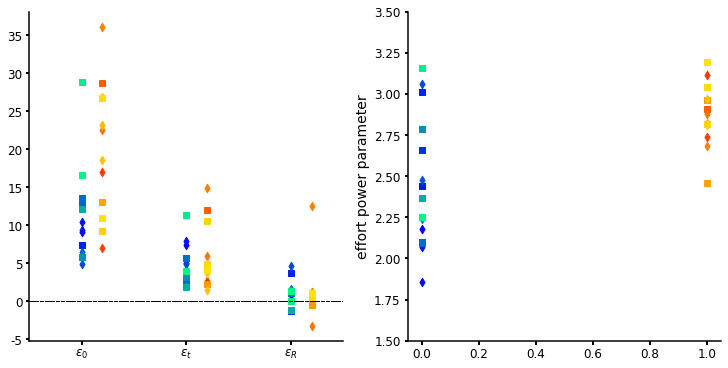

In [59]:
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 'RatM53', 'RatM54']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ylabels = [r'$\epsilon_0$', r"$\epsilon_t$", r"$\epsilon_R$"]
ylims = [[-.2, 2.5], [-.05, .2], [-.15, .15],]


epsilon_0_intact = []
epsilon_t_intact = []
epsilon_R_intact = []
power_0_intact = []

epsilon_0_lesion = []
epsilon_t_lesion = []
epsilon_R_lesion = []
power_0_lesion = []

for animal in animalList:
    if animal in intact:
        x = np.arange(3)
        epsilon_0_intact.append(epsilon_0[animal])
        epsilon_t_intact.append(epsilon_t[animal])
        epsilon_R_intact.append(epsilon_R[animal])
        power_0_intact.append(power_0[animal])

    else:
        x = np.arange(3) + .2
        epsilon_0_lesion.append(epsilon_0[animal])
        epsilon_t_lesion.append(epsilon_t[animal])
        epsilon_R_lesion.append(epsilon_R[animal])
        power_0_lesion.append(power_0[animal])

    print(epsilon_0[animal], epsilon_t[animal], epsilon_R[animal])
    axs[0].scatter(x,  [epsilon_0[animal], epsilon_t[animal], epsilon_R[animal]], color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1])
    axs[0].set_title(f"")
    axs[0].set_xticks(np.arange(3))
    axs[0].set_xticklabels(ylabels)
    axs[0].set_xlim(-.5, 2.5)
    # axs.set_ylim(ylim)
    axs[0].axhline(0, color='black', linestyle='--', linewidth=1)

    x = 0 if animal in intact else 1
    axs[1].scatter(x, power_0[animal], color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1])
    axs[1].set_ylim(1.5, 3.5)

# axs[0].set_xlabel("effort sensibility parameter")

axs[1].set_ylabel("effort power parameter")

In [60]:
perm = exact_mc_perm_test(epsilon_0_intact, epsilon_0_lesion, 10000)
print(f'p = {perm}')

perm = exact_mc_perm_test(epsilon_t_intact, epsilon_t_lesion, 10000)
print(f'p = {perm}')

perm = exact_mc_perm_test(epsilon_R_intact, epsilon_R_lesion, 10000)
print(f'p = {perm}')

perm = exact_mc_perm_test(power_0_intact, power_0_lesion, 10000)
print(f'p = {perm}')


p = 0.0107
p = 0.3638
p = 0.916
p = 0.0019


In [45]:
np.median(power_0_intact)

2.375843241433299

In [46]:
np.median(power_0_lesion)

2.9205782944291547